# Training Notebook
Notebook for training the acoustic model of my speech 2 text AI.
### To-Do
* [x] Build data loaders
* [x] Write code to convert wav to log mel spectrograms
* [ ] Add SpecAugment to improve training
* [ ] Move spectrogram conversion and SpecAugment to separate module
* [x] Build acoustic model
* [ ] Move acoustic model to a separate module
* [ ] Training loop
* [ ] Validation loop
* [ ] Perform training
* [ ] Training visualization
### Post-Acoustic Model
* [ ] Implement beam search or similar algorithm
* [ ] Add Language model (character-level LM?) 

In [1]:
import torch
import torchaudio
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import utilities

### Multithreading in Notebook
Apparently there is a limitation with pytorch multithreading in notebooks that causes the notebook to hang if `num_

### Hyper Parameters

In [2]:
num_classes = 28
# n_feats = 81 # decided earlier based on how mel spectrograms were generated
dropout = 0.1
dense_size = 128
hidden_size = 1024
num_layers = 1

batch_size = 16
learning_rate = 0.001
num_workers = 0

## Build Data Loaders
Data loaders will be necessary to manage data when running training.

In [3]:
class LogMelSpec(nn.Module):
    
    def __init__(self, sample_rate=8000, n_mels=128, win_length=160, hop_length=80):
        super(LogMelSpec, self).__init__()
        self.transform = torchaudio.transforms.MelSpectrogram(
                            sample_rate=sample_rate, n_mels=n_mels,
                            win_length=win_length, hop_length=hop_length)
        
    def forward(self, x):
        x = self.transform(x) # mel spectrogram
        x = np.log(x + 1e-14) # logarithm, add small value to avoid divergence
        return x

In [4]:
class DataSet(torch.utils.data.Dataset):
        
    def __init__(self, json_path, sample_rate, n_feats, specaug_rate, specaug_policy, time_mask, freq_mask,
                 valid=False, shuffle=True, text_to_int=True, log_ex=True):
        self.log_ex = log_ex
        self.text_process = utilities.TextProcess()
        
        print("Loading data json file from", json_path)
        self.data = pd.read_json(json_path, lines=True)
        
        if valid: # 
            self.audio_transforms = torch.nn.Sequential(
                LogMelSpec(sample_rate=sample_rate, n_mels=n_feats, win_length=160, hop_length=80)
            )
            
        else:
            self.audio_transforms = torch.nn.Sequential(
                LogMelSpec(sample_rate=sample_rate, n_mels=n_feats, win_length=160, hop_length=80),
                #SpecAugment(specaug_rate, specaug_policy, freq_mask, time_mask) # To-do: Add spec augment
            ) 
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()
        
        try:
            file_path = self.data.key.iloc[idx]
            waveform, _ = torchaudio.load(file_path)
            label = self.text_process.text_to_int_seq(self.data['text2'].iloc[idx])
            spectrogram = self.audio_transforms(waveform) # (channel, feature, time)
            spec_len = spectrogram.shape[-1] // 2
            label_len = len(label)
            if spec_len < label_len:
                raise Exception('spectrogram len is bigger then label len')
            if spectrogram.shape[0] > 1:
                raise Exception('dual channel, skipping audio file %s'%file_path)
            #if spectrogram.shape[2] > 1650:
            #    raise Exception('spectrogram too big. size %s'%spectrogram.shape[2])
            if label_len == 0:
                raise Exception('label len is zero... skipping %s'%file_path)
        except Exception as e:
            if self.log_ex:
                print(str(e), file_path)
            return self.__getitem__(idx - 1 if idx != 0 else idx + 1)  
                
        return spectrogram, label, spec_len, label_len
   
    def describe(self):
        return self.data.describe()
    
def collate_fn_padd(data):
    '''
    Padds batch of variable length
    
    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitary tensors
    '''
    spectrograms = []
    labels = []
    input_lens = []
    label_lens = []
    for (spectrogram, label, input_len, label_len) in data:
        if spectrogram is None:
            continue
        spectrograms.append(spectrogram.squeeze(0).transpose(0,1))
        labels.append(torch.Tensor(label))
        input_lens.append(input_len)
        label_lens.append(label_len)
        
    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2,3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)
    input_lens = input_lens
    label_lens = label_lens
    
    return spectrograms, labels, input_lens, label_lens

### Data Parameters

In [5]:
sample_rate = 8000
n_feats = 81
specaug_rate = 0.5
specaug_policy = 3
time_mask = 70
freq_mask = 15

train_path = 'F:/cv-corpus-11.0-2022-09-21/en/train.json'
train_dataset = DataSet(train_path, sample_rate, n_feats, specaug_rate, specaug_policy, time_mask, freq_mask)

test_path = 'F:/cv-corpus-11.0-2022-09-21/en/test.json'
val_dataset = DataSet(test_path, sample_rate, n_feats, specaug_rate, specaug_policy, time_mask, freq_mask)

Loading data json file from F:/cv-corpus-11.0-2022-09-21/en/train.json
Loading data json file from F:/cv-corpus-11.0-2022-09-21/en/test.json


In [6]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          num_workers=num_workers,
                          collate_fn=collate_fn_padd,
                          pin_memory = True)
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=batch_size,
                          num_workers=num_workers,
                          collate_fn=collate_fn_padd,
                          pin_memory = True)

In [7]:
len(train_dataset)

853579

### Visualizing Distribution of Spectrogram and Label Lengths
Plot a subsample of the lengths of the spectrograms and labels to get a sense of how long the data is. We then choose maximums that encompass most (but not necessarily all) of the data.

  0%|          | 0/1000 [00:00<?, ?it/s]

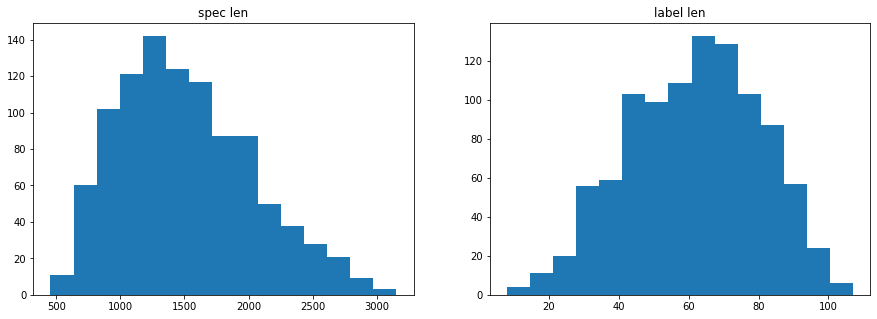

In [8]:
if True:
    spec_len_list = []
    label_len_list = []
    for i in tqdm(range(1000)):
        spec_len_list.append(val_dataset[i][2]);
        label_len_list.append(val_dataset[i][3]);

    fig1, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(15,5))
    ax1.hist(spec_len_list, bins=15);
    ax1.set_title('spec len');
    ax2.hist(label_len_list, bins=15)
    ax2.set_title('label len');

In [9]:
max_spec_len = 0
max_label_len = 0

check_max = False

if check_max:
    for i in tqdm(range(len(test_set))):
        max_spec_len = max(max_spec_len, val_dataset[i][2])
        max_label_len = max(max_label_len, val_dataset[i][3])

    print("max_spec_len: ", max_spec_len)
    print("max_label_len: ", max_label_len)

else:
    max_spec_len = 4096
    max_label_len = 256

### Visualizing Log-Mel Spectrograms
Plotting the log of the Mel spectrograms of the dataset. Confirming that the audio data is being converted.

In [10]:
import librosa

def plot_spectrogram(spec, title=None, ylabel='Log Frequency', aspect='auto'):
    fig, axs = plt.subplots()
    axs.set_title(title)
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    spec = librosa.power_to_db(spec)
    im = axs.imshow(spec, origin="lower", aspect=aspect)
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

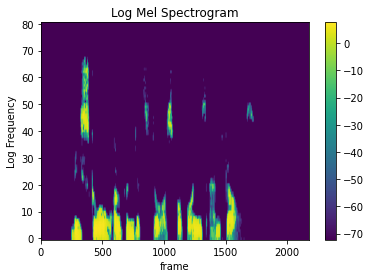

the school opened its doors for boys and girls


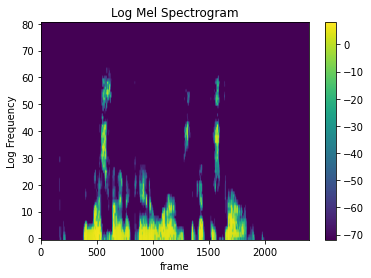

you must find a can of worms to get this power up


In [11]:
idx = 0
plot_spectrogram(val_dataset[idx][0][0], title="Log Mel Spectrogram")
print(val_dataset.text_process.int_to_text_seq(val_dataset[idx][1]))
idx = 1024
plot_spectrogram(val_dataset[idx][0][0], title="Log Mel Spectrogram")
print(val_dataset.text_process.int_to_text_seq(val_dataset[idx][1]))

## Build Model
Build the neural network for the acoustic model.

### Model

In [12]:
class DropNormCNN1D(nn.Module):
    def __init__(self, n_feats, dropout, keep_shape=False):
        super(DropNormCNN1D, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(n_feats)
        self.keep_shape = keep_shape
        
    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.norm(x)
        x = F.gelu(x)
        x = self.dropout(x)
        if self.keep_shape:
            return x.transpose(1,2)
        else:
            return x

class AcousticModel(nn.Module):
    def __init__(self, hidden_size, num_classes, n_feats, dense_size, num_layers, dropout):
        super(AcousticModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.cnn = nn.Sequential(
            nn.Conv1d(n_feats, n_feats, 10, 2, padding=10//2),
            DropNormCNN1D(n_feats, dropout),
        )
        self.dense = nn.Sequential(
            nn.Linear(n_feats, dense_size),
            nn.LayerNorm(dense_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dense_size, dense_size),
            nn.LayerNorm(dense_size),
            nn.GELU(),
            nn.Dropout(dropout),
        )
        self.lstm = nn.LSTM(input_size=dense_size, hidden_size=hidden_size,
                            num_layers=num_layers, dropout = 0.0,
                            bidirectional = False)
        self.layer_norm2 = nn.LayerNorm(hidden_size)
        self.dropout2 = nn.Dropout(dropout)
        self.final_fc = nn.Linear(hidden_size, num_classes)
        
    def _init_hidden(self, batch_size):
        n, hs = self.num_layers, self.hidden_size
        return (torch.zeros(n*1, batch_size, hs),
                torch.zeros(n*1, batch_size, hs))
    
    def forward(self, x, hidden):
        x = x.squeeze(1) # batch, feature, time
        x = self.cnn(x) # batch, time, feature
        x = self.dense(x) # batch, time, feature
        x = x.transpose(0, 1) # time, batch, feature
        out, (hn, cn) = self.lstm(x, hidden) # note hidden = (h0, c0)
        x = self.layer_norm2(out)
        x = F.gelu(x)
        x = self.dropout2(x) # time, batch, n_class
        return self.final_fc(x), (hn, cn)

In [13]:
model = AcousticModel(hidden_size, num_classes, n_feats, dense_size, num_layers, dropout)

## Trainer
Set up loss function, optimizer, and training loop.

In [14]:
loss_fn = nn.CTCLoss(blank=27, zero_infinity=True)

In [15]:
optimizer = optim.AdamW(model.parameters(), learning_rate)

In [16]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch_index, batch_list, loss_list, batches=100):
    running_loss = 0.
    last_loss = 0.
    i = 0
    
    for data in tqdm(train_loader):
        spectrograms, labels, input_lens, label_lens = data
        bs = spectrograms.shape[0]
        hidden = model._init_hidden(bs)
        hn, c0 = hidden[0], hidden[1]
        
        # zero gradients for every batch
        optimizer.zero_grad()
        
        # make predictions for this batch
        outputs, _ = model(spectrograms, (hn, c0))
        outputs = F.log_softmax(outputs, dim=2)
        
        # compute loss and its gradients
        loss = loss_fn(outputs, labels, input_lens, label_lens)
        loss.backward()
        
        # adjust learning weights
        optimizer.step()
        
        # gather data and report
        running_loss += loss.item()
        if i % batches == batches-1:
            last_loss = running_loss / batches # loss per batch
            print('Batch {} loss: {}'.format(i + 1, last_loss))
            batch_list.append(epoch_index*len(train_loader) + i + 1)
            loss_list.append(last_loss)
            running_loss = 0
            
        i += 1

batch_list = []
loss_list = []
train_one_epoch(model, train_loader, loss_fn, optimizer, 0, batch_list, loss_list, batches = 1)